In [2]:
import numpy as np
import matplotlib.pyplot as plt
import h5py as h5
import emcee
import torch
import sacc
import corner
import os
import itertools
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.stats import qmc
from IPython.display import clear_output

from copy import deepcopy

import src.training as training
import src.models as models

from multiprocessing import Pool, cpu_count
from time import time
from importlib import reload
reload(training)
reload(models)

seed = 14
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

# set device for all tensors
device = 'cuda'

## Train a standard emulator

Epoch 1 - avg loss: 0.9230384528636932 - Strike: 0
Epoch 2 - avg loss: 0.5775228664278984 - Strike: 0
Epoch 3 - avg loss: 0.3114722669124603 - Strike: 0
Epoch 4 - avg loss: 0.25751667469739914 - Strike: 0
Epoch 5 - avg loss: 0.2026962712407112 - Strike: 0
Epoch 6 - avg loss: 0.1825879104435444 - Strike: 0
Epoch 7 - avg loss: 0.17414233833551407 - Strike: 0
Epoch 8 - avg loss: 0.16031264141201973 - Strike: 1
Epoch 9 - avg loss: 0.15355735272169113 - Strike: 0
Epoch 10 - avg loss: 0.14532724395394325 - Strike: 0
Epoch 11 - avg loss: 0.13828931748867035 - Strike: 1
Epoch 12 - avg loss: 0.13052699714899063 - Strike: 2
Epoch 13 - avg loss: 0.12423799559473991 - Strike: 0
Epoch 14 - avg loss: 0.11678321659564972 - Strike: 0
Epoch 15 - avg loss: 0.11048285104334354 - Strike: 0
Epoch 16 - avg loss: 0.10436586104333401 - Strike: 0
Epoch 17 - avg loss: 0.09811454638838768 - Strike: 0
Epoch 18 - avg loss: 0.09224285371601582 - Strike: 0
Epoch 19 - avg loss: 0.08645260520279408 - Strike: 0
Epoch 2

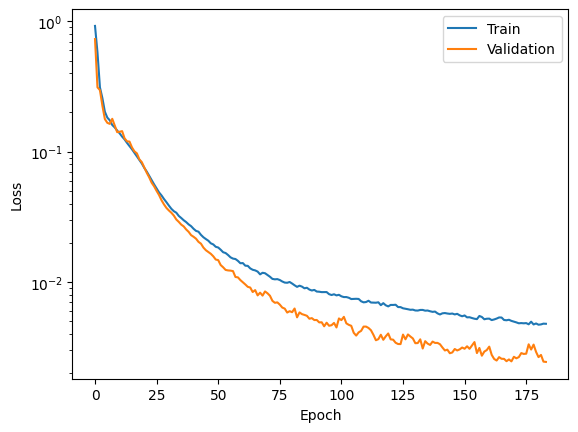

In [17]:
filepath = 'data/42_dndz_nsamples=24000.h5'
with h5.File(filepath, 'r') as f:
    X = f['hypercube'][:]
    y = f['c_ells'][:]

# Take log of y
y_log = np.log(y)

# Split into test training and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y_log, train_size=20000, random_state=seed)

# Send data to torch tensors
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).to(device)

#Scale the data
ScalerX = training.TorchStandardScaler()
X_train = ScalerX.fit_transform(X_train)
X_test = ScalerX.transform(X_test)

ScalerY = training.TorchStandardScaler()
y_train = ScalerY.fit_transform(y_train)
y_test = ScalerY.transform(y_test)

train_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_data, batch_size=5000, shuffle=False)

X_val = X_test
y_val = y_test
# Define the model
model = models.FastWeightCNN(
    input_size=10,
    latent_dim=(16,16),
    output_size=750,
    dropout_rate=0.2
)
model.to(device)

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0)

# Define the loss function
loss_fn = torch.nn.MSELoss()

force_stop = np.inf

train_losses = []
val_losses = []
converged = False
best_val_loss = np.inf
strike = 0
epoch = 0
start = time()
while not converged:
    #clear_output(wait=True)
    epoch_loss = 0
    batch_count = 0
    model.train()
    for X_batch, y_batch in train_loader:

        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        batch_count += 1

    # Check for convergence
    epoch += 1
    model.eval()
    with torch.no_grad():
        y_pred = model(X_val)
        val_loss = loss_fn(y_pred, y_val).item()
        val_losses.append(val_loss)

    if best_val_loss - val_loss < 1e-4:
        strike += 1
        if strike > 20 or epoch > force_stop:
            converged = True
            print('Validation loss has not improved for 20 epochs. Converged.')
    else:
        strike = 0
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss

    avg_epoch_loss = epoch_loss / batch_count
    train_losses.append(avg_epoch_loss)
    print(f'Epoch {epoch} - avg loss: {avg_epoch_loss} - Strike: {strike}')
train_time = time()-start

#original_model = deepcopy(pt_model.state_dict())

plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()

Pretraining emualtor with standard method...
torch.Size([4000, 10]) torch.Size([4000, 750])
Pre-training emulator with 20000 samples...
Epoch 1 - avg loss: 0.9019859731197357 - Strike: 0
Epoch 2 - avg loss: 0.49178496748209 - Strike: 0
Epoch 3 - avg loss: 0.30769966542720795 - Strike: 0
Epoch 4 - avg loss: 0.2381531298160553 - Strike: 0
Epoch 5 - avg loss: 0.2021731361746788 - Strike: 0
Epoch 6 - avg loss: 0.19005269184708595 - Strike: 0
Epoch 7 - avg loss: 0.17322197929024696 - Strike: 1
Epoch 8 - avg loss: 0.16658013686537743 - Strike: 0
Epoch 9 - avg loss: 0.15636435896158218 - Strike: 0
Epoch 10 - avg loss: 0.14825639873743057 - Strike: 1
Epoch 11 - avg loss: 0.13979315385222435 - Strike: 0
Epoch 12 - avg loss: 0.1317896917462349 - Strike: 0
Epoch 13 - avg loss: 0.12368864938616753 - Strike: 0
Epoch 14 - avg loss: 0.11663034372031689 - Strike: 0
Epoch 15 - avg loss: 0.10976817645132542 - Strike: 0
Epoch 16 - avg loss: 0.10512835904955864 - Strike: 0
Epoch 17 - avg loss: 0.099077478

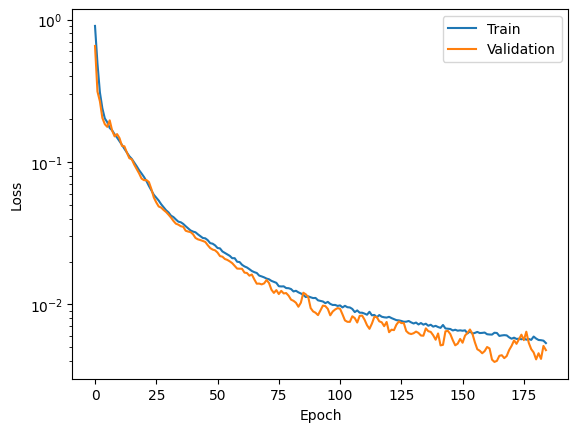

In [21]:
pretrain_file = 'data/42_dndz_nsamples=24000.h5'
n_train = 20000

print('Pretraining emualtor with standard method...')
# Load pretraining data for standard training emulator
train_data, _, X_val, y_val, _, _ = training.load_train_test_val(
    filepath=pretrain_file, n_train=n_train, n_val=4000, n_test=None, seed=14,
    device=device
)
print(X_val.size(), y_val.size())

# Pretrain an emulator in the standard way
train_loader = DataLoader(train_data, batch_size=5000, shuffle=False)
print('Pre-training emulator with {} samples...'.format(len(train_data)))
pretrain_model, pretrain_time, train_losses, val_losses = training.train_standard_emulator(train_loader, X_val, y_val, device=device)
print('Pre-training time:', pretrain_time)

plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()

## Define functions for testing loop

In [6]:
def load_train_test(n_samples, seed=14):
    # test with random samples
    filepath = 'data/mcmc_dndz_nsamples=20000.h5'
    with h5.File(filepath, 'r') as f:
        X = f['hypercube'][:]
        y = f['c_ells'][:]

    # split into test training and validation sets
    # Fix test size so different sampling don't test on different numbers of samples
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, train_size=n_samples,  test_size=18000, random_state=seed, shuffle=True
    )

    # Take log of y
    y_train = np.log(y_train)
    y_test = np.log(y_test)

    # Send data to torch tensors
    X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
    X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
    y_test = torch.tensor(y_test, dtype=torch.float32).to(device)

    #Scale the data
    ScalerX = training.TorchStandardScaler()
    X_train = ScalerX.fit_transform(X_train)
    X_test = ScalerX.transform(X_test)

    ScalerY = training.TorchStandardScaler()
    y_train = ScalerY.fit_transform(y_train)
        
    train_data = TensorDataset(X_train, y_train)
    
    test_data = TensorDataset(X_test, y_test)
    test_loader = DataLoader(test_data, batch_size=2048, shuffle=False)

    return train_data, test_loader, ScalerY

In [7]:
# Test loading to ensure seed is working
# Output should be the same for all iterations
for _ in range(10):
    train_data, test_loader, ScalerY = load_train_test(n_samples=100, seed=14)
    print(train_data[:][0][0])
    clear_output(wait=True)


tensor([-1.4670, -0.1221, -0.0515, -0.7901,  1.2138, -0.8516, -0.9306,  0.3755,
         0.2991,  1.4462], device='cuda:0')


In [19]:
def finetune_pretrained(model, n_epochs, dropout=True):
    # Define new optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

    model.to(device)
    
    if dropout:
        model.train()
    else:
        model.eval()
        
    for _ in range(n_epochs):
        epoch_loss = 0
        batch_count = 0
        for X_batch, y_batch in train_loader:

            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            batch_count += 1

In [9]:
def test_model(model, test_loader, ScalerY, weights=None):
    model.eval()
    y_pred = torch.tensor([]).to(device)
    y_test = torch.tensor([]).to(device)
    for X_batch, y_batch in test_loader:
        model.eval()
        with torch.no_grad(): # don't compute gradients during inference
            y_pred_batch = model(X_batch, params=weights)
            y_pred = torch.cat((y_pred, y_pred_batch), dim=0)
            y_test = torch.cat((y_test, y_batch), dim=0)
    # Inverse transform the data
    y_pred = ScalerY.inverse_transform(y_pred)

    y_pred_np = y_pred.cpu().numpy()
    y_test_np = y_test.cpu().numpy()

    # Exponentiate the data
    y_pred_np = np.exp(y_pred_np)
    y_test_np = np.exp(y_test_np)

    # Compute mean absolute percentage error along the test set
    apes = np.abs((y_test_np - y_pred_np) / y_test_np) * 100
    ell_ape = np.mean(apes, axis=1)
    maml_mape = np.mean(apes, axis=0)
    maml_frate = len(ell_ape[ell_ape > 5]) / len(ell_ape)

    return maml_mape, maml_frate

In [10]:
# load MAML model
maml_model = models.FastWeightCNN(
    input_size=10,
    latent_dim=(16,16),
    output_size=750,
    dropout_rate=0.2
)

# Create a new MetaLearner instance
metalearner = training.MetaLearner(
    model=maml_model,
    outer_lr=0.01,
    inner_lr=0.001,
    loss_fn=torch.nn.MSELoss,
    beta1=0.9,
    beta2=0.999,
    epsilon=1e-8,
    seed=14,
    device=device
)

# Load metaleraner weights
metalearner.model.load_state_dict(
    torch.load(
        '{}batch_{}samples_{}tasks_metalearner_weights.pt'.format(5, 1000, 20)
    )
)

pt_model.to(device)

FastWeightCNN(
  (fc1): Linear(in_features=10, out_features=256, bias=True)
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(4, 4), dilation=(4, 4))
  (dropout): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=16384, out_features=750, bias=True)
)

## Loop through combinations of samples and epochs and test models
### Here we investigate the variation in model performance as a function of the non-determinism of the cuDNN library

In [ ]:
# n_samples = np.linspace(100, 1000, 5).astype(int)
# n_epochs = [32]
# smooth = 1

# pretrain_mapes = np.zeros((len(n_samples), len(n_epochs), smooth, y_train.shape[1]))
# pretrain_frates = np.zeros((len(n_samples), len(n_epochs), smooth))
# maml_mapes = np.zeros((len(n_samples), len(n_epochs), smooth, y_train.shape[1]))
# maml_frates = np.zeros((len(n_samples), len(n_epochs), smooth))
# pretrain_times = np.zeros((len(n_samples), len(n_epochs), smooth))
# maml_times = np.zeros((len(n_samples), len(n_epochs), smooth))

# for i, samples in enumerate(n_samples):
#     for j, epochs in enumerate(n_epochs):
#         # load the data
#         train_data, test_loader, ScalerY = load_train_test(samples)
#         train_loader = DataLoader(train_data, batch_size=5000, shuffle=False) # train on all samples at once

#         for k in range(smooth):
#             # finetune the model
#             start = time()
#             # load the original model
#             pt_model.load_state_dict(original_model)
#             finetune_pretrained(pt_model, epochs)
#             pretrain_ft_time = time()-start

#             # finetune MAML model
#             start = time()
#             X_train, y_train = train_data[:]
#             task_weights, _ = metalearner.finetune(
#                 X_train, y_train, adapt_steps=epochs, use_new_adam=True
#             )
#             maml_ft_time = time()-start

#             # test the models
#             maml_mape, maml_frate = test_model(metalearner.model, test_loader, ScalerY, weights=task_weights)
#             pt_mape, pt_frate = test_model(pt_model, test_loader, ScalerY)

#             # save results
#             pretrain_mapes[i, j, k] = pt_mape
#             pretrain_frates[i, j, k] = pt_frate
#             maml_mapes[i, j, k] = maml_mape
#             maml_frates[i, j, k] = maml_frate
#             pretrain_times[i, j, k] = pretrain_ft_time
#             maml_times[i, j, k] = maml_ft_time

#         print(f'Finished {samples} samples and {epochs} epochs')

# # save results to file
# fname = 'pretrain_vs_maml_results.h5'
# with h5.File(fname, 'w') as f:
#     f.create_dataset('pretrain_mapes', data=pretrain_mapes)
#     f.create_dataset('pretrain_frates', data=pretrain_frates)
#     f.create_dataset('maml_mapes', data=maml_mapes)
#     f.create_dataset('maml_frates', data=maml_frates)
#     f.create_dataset('pretrain_times', data=pretrain_times)
#     f.create_dataset('maml_times', data=maml_times)
#     f.create_dataset('n_samples', data=n_samples)
#     f.create_dataset('n_epochs', data=n_epochs)
#     f.create_dataset('smooth', data=smooth)

Finished 100 samples and 32 epochs
Finished 325 samples and 32 epochs
Finished 550 samples and 32 epochs
Finished 775 samples and 32 epochs
Finished 1000 samples and 32 epochs


## Plot results

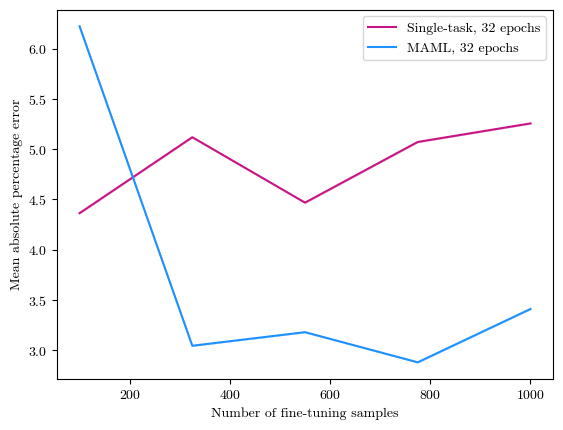

In [25]:
# compute mean and std of mapes
pt_mapes_mean = np.mean(np.mean(pretrain_mapes, axis=3), axis=2)
pt_mapes_std = np.std(np.mean(pretrain_mapes, axis=3), axis=2)
maml_mapes_mean = np.mean(np.mean(maml_mapes, axis=3), axis=2)
maml_mapes_std = np.std(np.mean(maml_mapes, axis=3), axis=2)

# plot the results
linestlyes = ['-', '--', ':']
for i, epochs in enumerate(n_epochs):
    plt.plot(n_samples, pt_mapes_mean[:, i], label=f'Single-task, {epochs} epochs', color='mediumvioletred', ls=linestlyes[i])
    plt.fill_between(
        n_samples,
        pt_mapes_mean[:, i]-pt_mapes_std[:, i],
        pt_mapes_mean[:, i]+pt_mapes_std[:, i],
        alpha=0.2,
        color='mediumvioletred'
    )

    plt.plot(n_samples, maml_mapes_mean[:, i], label=f'MAML, {epochs} epochs', color='dodgerblue', ls=linestlyes[i])
    plt.fill_between(
        n_samples,
        maml_mapes_mean[:, i]-maml_mapes_std[:, i],
        maml_mapes_mean[:, i]+maml_mapes_std[:, i],
        alpha=0.2,
        color='dodgerblue'
    )
    plt.xlabel('Number of fine-tuning samples')
    plt.ylabel('Mean absolute percentage error')

plt.legend()

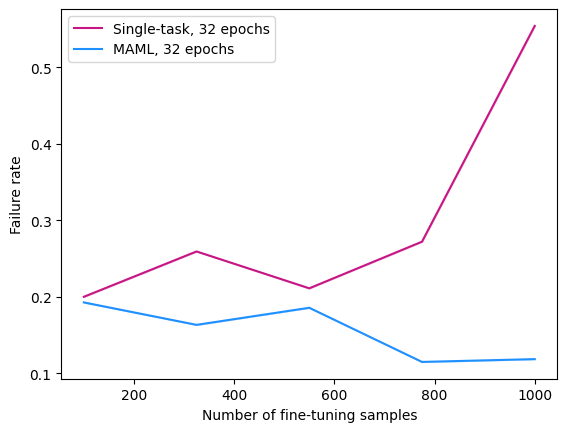

In [13]:
pt_frates_mean = np.mean(pretrain_frates, axis=2)
pt_frates_std = np.std(pretrain_frates, axis=2)
maml_frates_mean = np.mean(maml_frates, axis=2)
maml_frates_std = np.std(maml_frates, axis=2)

for i, epochs in enumerate(n_epochs):
    plt.plot(n_samples, pt_frates_mean[:, i], label=f'Single-task, {epochs} epochs', color='mediumvioletred', ls=linestlyes[i])
    plt.fill_between(
        n_samples,
        pt_frates_mean[:, i]-pt_frates_std[:, i],
        pt_frates_mean[:, i]+pt_frates_std[:, i],
        alpha=0.2,
        color='mediumvioletred'
    )

    plt.plot(n_samples, maml_frates_mean[:, i], label=f'MAML, {epochs} epochs', color='dodgerblue', ls=linestlyes[i])
    plt.fill_between(
        n_samples,
        maml_frates_mean[:, i]-maml_frates_std[:, i],
        maml_frates_mean[:, i]+maml_frates_std[:, i],
        alpha=0.2,
        color='dodgerblue'
    )
    plt.xlabel('Number of fine-tuning samples')
    plt.ylabel('Failure rate')

plt.legend()

### Here we investigate the model performance w.r.t to variation in the training data AND cuDNN, by using a different random seed for the data split

- This of course will be compounded by the cuDNN optimisation variability. I think this is fine, as realistically this is part and parcel of using NNs on GPUs, given running deterministically is 20x slower.
- Therefore what we are looking at in reality is a large scale variability in performance due to differences in dropout, optimisation and sample selection.

In [ ]:
# n_samples = np.linspace(100, 1000, 5).astype(int)
# n_epochs = [64]
# smooth = 5

# pretrain_mapes = np.zeros((len(n_samples), len(n_epochs), smooth, y_train.shape[1]))
# pretrain_frates = np.zeros((len(n_samples), len(n_epochs), smooth))
# maml_mapes = np.zeros((len(n_samples), len(n_epochs), smooth, y_train.shape[1]))
# maml_frates = np.zeros((len(n_samples), len(n_epochs), smooth))
# pretrain_times = np.zeros((len(n_samples), len(n_epochs), smooth))
# maml_times = np.zeros((len(n_samples), len(n_epochs), smooth))
# seeds = []

# for i, samples in enumerate(n_samples):
#     for j, epochs in enumerate(n_epochs):

#         for k in range(smooth):

#             seed = np.random.randint(1000)

#             # load the data
#             train_data, test_loader, ScalerY = load_train_test(samples, seed=seed)
#             train_loader = DataLoader(train_data, batch_size=5000, shuffle=False) # train on all samples at once

#             # finetune the model
#             start = time()
#             # load the model with the original weights
#             pt_model.load_state_dict(original_model)
#             finetune_pretrained(pt_model, epochs)
#             pretrain_ft_time = time()-start

#             # finetune MAML model
#             start = time()
#             X_train, y_train = train_data[:]
#             task_weights, _ = metalearner.finetune(
#                 X_train, y_train, adapt_steps=epochs, use_new_adam=True
#             )
#             maml_ft_time = time()-start

#             # test the models
#             maml_mape, maml_frate = test_model(metalearner.model, test_loader, ScalerY, weights=task_weights)
#             pt_mape, pt_frate = test_model(pt_model, test_loader, ScalerY)

#             # save results
#             pretrain_mapes[i, j, k] = pt_mape
#             pretrain_frates[i, j, k] = pt_frate
#             maml_mapes[i, j, k] = maml_mape
#             maml_frates[i, j, k] = maml_frate
#             pretrain_times[i, j, k] = pretrain_ft_time
#             maml_times[i, j, k] = maml_ft_time
#             seeds.append(seed)

#         print(f'Finished {samples} samples and {epochs} epochs')

Parameter containing:
tensor([[-0.0737, -0.4476,  0.3012,  ..., -0.1467, -0.0979, -0.0274],
        [-0.4064,  0.0973, -0.0813,  ...,  0.1210,  0.0517, -0.0746],
        [-0.1948,  0.2245,  0.0936,  ...,  0.0946, -0.0334, -0.1094],
        ...,
        [ 0.2024,  0.2615,  0.1454,  ...,  0.2243, -0.1760,  0.1209],
        [-0.3563, -0.1751,  0.1056,  ...,  0.0608, -0.0511,  0.2025],
        [-0.3494,  0.2985,  0.0916,  ...,  0.1400,  0.0096, -0.1599]],
       device='cuda:0', requires_grad=True)
Parameter containing:
tensor([[-0.0798, -0.4497,  0.3045,  ..., -0.1455, -0.0800, -0.0443],
        [-0.4100,  0.0919, -0.0869,  ...,  0.1124,  0.0545, -0.0830],
        [-0.1833,  0.2411,  0.1059,  ...,  0.0981, -0.0343, -0.1041],
        ...,
        [ 0.1980,  0.2732,  0.1494,  ...,  0.2208, -0.1864,  0.1356],
        [-0.3566, -0.1764,  0.1047,  ...,  0.0645, -0.0531,  0.1988],
        [-0.3572,  0.2944,  0.0784,  ...,  0.1365,  0.0338, -0.1598]],
       device='cuda:0', requires_grad=True)


In [10]:
# load results
fname = 'maml_compare_pretrained_nsmooth=10.h5'
with h5.File(fname, 'r') as f:
    pretrain_times = f['pretrain_times'][:]
    pretrain_mapes = f['pretrain_mapes'][:]
    pretrain_frates = f['pretrain_frates'][:]
    maml_times = f['maml_times'][:]
    maml_mapes = f['maml_mapes'][:]
    maml_frates = f['maml_frates'][:]
    seeds = f['seeds'][:]

n_samples = np.linspace(100, 1000, 20).astype(int)

In [11]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['cmr10']
plt.rcParams['mathtext.fontset'] ='cm'
plt.rcParams['figure.facecolor'] = 'white'
plt.rc('axes', unicode_minus=False)
plt.rc('axes.formatter', use_mathtext=True)

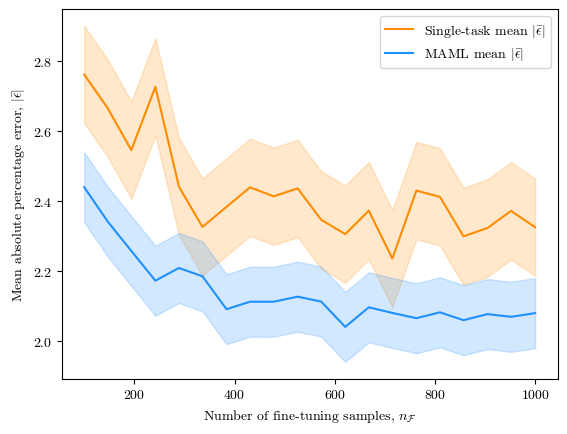

In [12]:
# compute mean and std of mapes
pt_mapes_mean = np.mean(pretrain_mapes, axis=1)
pt_mapes_std = np.std(pt_mapes_mean)
maml_mapes_mean = np.mean(maml_mapes, axis=1)
maml_mapes_std = np.std(maml_mapes_mean)

plt.plot(n_samples, pt_mapes_mean, label=r'Single-task mean $|\bar{\epsilon}|$', color='darkorange')
plt.fill_between(
    n_samples,
    pt_mapes_mean-pt_mapes_std,
    pt_mapes_mean+pt_mapes_std,
    alpha=0.2,
    color='darkorange'
)

plt.plot(n_samples, maml_mapes_mean, label=r'MAML mean $|\bar{\epsilon}|$', color='dodgerblue')
plt.fill_between(
    n_samples,
    maml_mapes_mean-maml_mapes_std,
    maml_mapes_mean+maml_mapes_std,
    alpha=0.2,
    color='dodgerblue'
)
plt.xlabel(r'Number of fine-tuning samples, $n_\mathcal{F}$')
plt.ylabel(r'Mean absolute percentage error, $|\bar{\epsilon}|$')

plt.legend()
plt.savefig('maml_vs_pretrain_mapes.pdf', bbox_inches='tight')

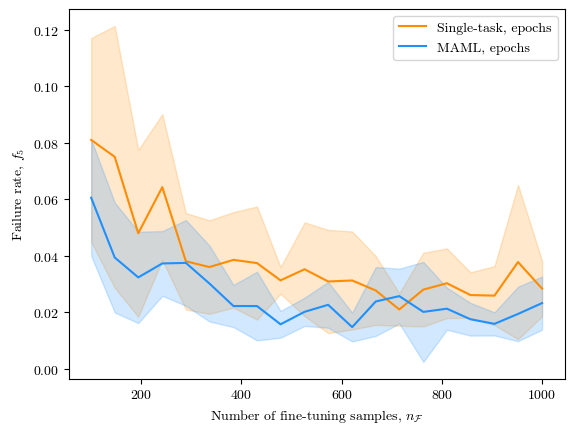

In [13]:
pt_frates_mean = np.mean(pretrain_frates, axis=1)
pt_frates_std = np.std(pretrain_frates, axis=1)
maml_frates_mean = np.mean(maml_frates, axis=1)
maml_frates_std = np.std(maml_frates, axis=1)

plt.plot(n_samples, pt_frates_mean, label=f'Single-task, epochs', color='darkorange')
plt.fill_between(
    n_samples,
    pt_frates_mean-pt_frates_std,
    pt_frates_mean+pt_frates_std,
    alpha=0.2,
    color='darkorange'
)

plt.plot(n_samples, maml_frates_mean, label=f'MAML, epochs', color='dodgerblue')
plt.fill_between(
    n_samples,
    maml_frates_mean-maml_frates_std,
    maml_frates_mean+maml_frates_std,
    alpha=0.2,
    color='dodgerblue'
)
plt.xlabel(r'Number of fine-tuning samples, $n_\mathcal{F}$')
plt.ylabel(r'Failure rate, $f_{5}$')

plt.legend()
plt.savefig('maml_vs_pretrain_frates.pdf', bbox_inches='tight')